In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import math
from typing import Tuple
import numpy as np
import copy
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils import data
from torch.autograd import Variable

# Transformer model

## embedding 

In [ ]:
class Embedder(nn.Module):
    def __init__(self,num_token,d_model):
        super(Embedder,self).__init__()
        self.embed = nn.Embedding(num_token,d_model)
    def forward(self,x):
        return self.embed(x)

## positional encoder

In [ ]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len=2048):
        super().__init__()
        self.d_model = d_model
        
        # create constant "positoinal encoding pe" matrix with values dependant on 
        #  position and i
        pe = torch.zeros(max_seq_len,d_model)
        for pos in range(max_seq_len):
            for i in range(0,d_model,2):
                pe[pos,i] = math.sin(pos/(10000** ((2*i)/d_model)))
                pe[pos,i+1] = math.cos(pos/(10000** ((2*(i+1))/d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)
        
    def forward(self,x):
        # make embedding larger so that its more important
        x = x * math.sqrt(self.d_model)
        
        # add constant to embedding
        seq_len = x.size(1)
        x = x + torch.nn.parameter.Parameter(self.pe[:,:seq_len], requires_grad=False).cuda()
        return x

## MultiHeadAttention

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout=0.3):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        # claculate Q, K, V representation of the token
        self.q_linear = nn.Linear(d_model,d_model)
        self.v_linear = nn.Linear(d_model,d_model)
        self.k_linear = nn.Linear(d_model,d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model,d_model)
        
    def forward(self,q,k,v,mask=None):
        bs = q.size(0)
        
        # perform linear operation and split into h heads
        k = self.k_linear(k).view(bs,-1,self.h,self.d_k)
        q = self.q_linear(q).view(bs,-1,self.h,self.d_k)
        v = self.v_linear(v).view(bs,-1,self.h,self.d_k)
        
        # transpose to get dimensions bs * heads * sequence_len * d_model
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
        
        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous().view(bs,-1,self.d_model)
        
        output = self.out(concat)
        
        return output
    
    # calculate attention
def attention(q, k, v, d_k, mask=None, dropout=None):
    scores = torch.matmul(q,k.transpose(2,-1)) / math.sqrt(d_k)
    
    if mask is not None:
        mask = mask.unsqueeze(1).cuda()
        scores = scores.masked_fill_(mask == 0, -1e9)
    
    scores = nn.functional.softmax(scores, dim=-1)
    
    if dropout:
        scores = dropout(scores)
    
    output = torch.matmul(scores, v)
    return output

# Feed-forward Network - 1024 -> 2048

In [ ]:
class FeedForward(nn.Module):
    def __init__(self,d_model,d_ff = 2048, dropout=0.3):
        super().__init__()
        self.linear1 = nn.Linear(d_model,d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff,d_model)
        self.relu = nn.ReLU()
    def forward(self,x):
        x = self.dropout(self.relu(self.linear1(x)))
        x = self.linear2(x)
        return x

# Layernorm

In [ ]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
        
        self.size = d_model
        
        # create two learnable parameters to calibrate normalization
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    
    def forward(self,x):
        norm = self.alpha * (x - x.mean(dim=-1,keepdim=True))/(x.std(dim=-1,keepdim=True)+self.eps)+self.bias
        return norm

# Transformer

## Encoder and Decoder

In [ ]:
# build one encoder layer with one multi-head attention layer and one feed-forward layer
class EncoderLayer(nn.Module):
    def __init__(self,d_model,heads,dropout=0.3):
        super().__init__()
        self.norm1 = Norm(d_model)
        self.norm2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(self,x,mask):
        x2 = self.norm1(x)
        x = x + self.dropout1(self.attn(x2,x2,x2,mask))
        x2 = self.norm2(x)
        x = x + self.dropout2(self.ff(x2))
        return x

# a decoder layer with two multi-head attention layers and one feed-forward layer
class DecoderLayer(nn.Module):
    def __init__(self,d_model,heads,dropout=0.1):
        super().__init__()
        self.norm1 = Norm(d_model)
        self.norm2 = Norm(d_model)
        self.norm3 = Norm(d_model)
        
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        
        self.attn1 = MultiHeadAttention(heads,d_model)
        self.attn2 = MultiHeadAttention(heads,d_model)
        self.ff=FeedForward(d_model).cuda()
        
    def forward(self,x,e_outputs,src_mask,trg_mask):
        x2 = self.norm1(x)
        x = x + self.dropout1(self.attn1(x2,x2,x2,trg_mask))
        x2 = self.norm2(x)
        x = x + self.dropout2(self.attn2(x2,e_outputs,e_outputs,src_mask))
        x2 = self.norm3(x)
        x = x + self.dropout3(self.ff(x2))
        return x
    
    

In [ ]:
# define a function that generate multiple layers:
def get_clones(module,N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

# encoder and decoder
class Encoder(nn.Module):
    def __init__(self,num_tokens,d_model,N,heads):
        super().__init__()
        self.N = N
        self.embed = Embedder(num_tokens,d_model) # num_tokens is vocabulary size
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(EncoderLayer(d_model,heads), N)
        self.norm = Norm(d_model)
        
    def forward(self,src,mask):
        x = self.embed(src)
        x = self.pe(x)
        for i in range(N):
            x = self.layers[i](x,mask)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self,num_tokens,d_model,N,heads):
        super().__init__()
        self.N = N
        self.embed = Embedder(num_tokens,d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(DecoderLayer(d_model,heads), N)
        self.norm = Norm(d_model)
    
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x,e_outputs,src_mask,trg_mask)
        return self.norm(x)

## Transformer

In [ ]:
class Transformer(nn.Module):
    def __init__(self,src_num_tokens,trg_num_tokens,d_model,N,heads):
        super().__init__()
        self.encoder = Encoder(src_num_tokens,d_model,N,heads)
        #self.decoder = Decoder(trg_num_tokens,d_model,N,heads)
        self.out = nn.Linear(d_model,trg_num_tokens)
    
    def forward(self, src, src_mask):
        e_outputs = self.encoder(src, src_mask)
        #d_output = self.decoder(trg,e_outputs,src_mask,trg_mask)
        output = self.out(e_outputs)
        return output

# customized dataset

In [ ]:
!cp "/content/drive/MyDrive/Customized Dataset - Pop/Val/customized_val_2048_every_20.npy" "/content/val_tokens.npy" 

In [ ]:
!cp "/content/drive/MyDrive/Customized Dataset - Pop/Train/customized_training_2048_every_20.npy" "/content/train_tokens.npy" 

In [ ]:
class customizedDataset(data.Dataset):
    def __init__(self,npy_path):
        # read in data
        self.data = np.load(npy_path)
        print("Dataset shape: ", self.data.shape)
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self,index):
        sequence = self.data[index]
        input_seq = sequence[:-1]
        output_seq = sequence[1:]
        return (input_seq,output_seq)

## dataloders

In [ ]:
train_dataset = customizedDataset("train_tokens.npy")
train_dataloader = data.DataLoader(train_dataset,batch_size=2,shuffle=True)

Dataset shape:  (335422, 2048)


In [ ]:

val_dataset = customizedDataset("val_tokens.npy")

set1 = list(range(0,len(val_dataset),5))
set2 = list(range(1,len(val_dataset),5))
set3 = list(range(2,len(val_dataset),5))
set4 = list(range(3,len(val_dataset),5))
set5 = list(range(3,len(val_dataset),5))

val1 = data.Subset(val_dataset,set1)
val2 = data.Subset(val_dataset,set2)
val3 = data.Subset(val_dataset,set3)
val4 = data.Subset(val_dataset,set4)
val5 = data.Subset(val_dataset,set4)

size=8

val_dataloader1 = data.DataLoader(val1,batch_size=size,shuffle=True)
val_dataloader2 = data.DataLoader(val2,batch_size=size,shuffle=True)
val_dataloader3 = data.DataLoader(val3,batch_size=size,shuffle=True)
val_dataloader4 = data.DataLoader(val4,batch_size=size,shuffle=True)
val_dataloader5 = data.DataLoader(val4,batch_size=size,shuffle=True)

val_dataloader = [val_dataloader1,
               val_dataloader2,val_dataloader3,val_dataloader4,val_dataloader5]

Dataset shape:  (32423, 2048)


In [ ]:
# check
X_train = next(iter(train_dataloader))
print(X_train[0].shape) # input seq
print(X_train[1].shape) # output seq

torch.Size([2, 2047])
torch.Size([2, 2047])


In [ ]:
# check
X_val = next(iter(val_dataloader[0]))
print(X_val[0].shape) # input seq
print(X_val[1].shape) # output seq

torch.Size([8, 2047])
torch.Size([8, 2047])


In [ ]:
len(train_dataloader)

167711

# Train and Validation Routine

In [ ]:
def create_mask(seq):
    size = seq.size(1)
    nopeak_mask = np.triu(np.ones((1,size,size)),k=1).astype("uint8")
    nopeak_mask = (torch.from_numpy(nopeak_mask)==0)
    return nopeak_mask
    

In [ ]:
def create_mask_pad(seq,paded_seq):
    return (seq != padded_seq).unsqueeze(1)

In [ ]:
a = torch.zeros((3,3),dtype=torch.long)
a[0,0] = 1
a[1,1] = 1
a[2,2] = 1
b = torch.ones((3,3),dtype=torch.long)
b = b * 3
c = a & b
c

tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])

In [ ]:
def evaluate(model,val_dataloader,device,loss_fn,num_vocab):
    model.eval()
    loss = 0
    steps = 0 # keep track of number of batches 
    with torch.no_grad():
        for batch in val_dataloader:
            steps += 1
            input_seq, output_seq = batch
            input_seq, output_seq = input_seq.long().to(device), output_seq.long().to(device)
            output = model(input_seq,None) #shape (batch,seq_len,num_vocab)
            output_flatten = output.view(-1,num_vocab) #shape (x,num_vocab)
            # output shape (batch,seq_len)
            loss +=  loss_fn(output_flatten,output_seq.view(-1)).item()
    loss = loss / steps
    print(f"Validation loss: {loss:.6f}\n")
    return loss

In [ ]:
from tqdm.auto import tqdm
def train(model,train_dataloader,val_dataloader,ep,print_frequency,loss_fn,
          optimizer,device,run,grad_clip=1,scheduler=None,
          num_vocab = 218,kind="Pop"):
    model.train()
    val_best = float("inf")
    
    # total number of training steps:
    num_steps = ep * len(train_dataloader) # len(train_dataloader) is how many batches for 1 epoch
    progress = tqdm(range(math.ceil(num_steps)))
    
    # calculate how often print the result
    print_every = math.floor(num_steps/print_frequency) # this is the # of batches processed before print
    
    
    # initialize
    steps = 0
    train_loss = []
    val_loss = []
    current_loss = 0
    
    for e in range(ep):
        for batch in train_dataloader:
            steps += 1
            input_seq, output_seq = batch
            input_seq, output_seq = input_seq.long().to(device), output_seq.long().to(device)
            
            optimizer.zero_grad()
            output = model(input_seq,None)
            output_flatten = output.view(-1,num_vocab)
            loss = loss_fn(output_flatten,output_seq.view(-1))
            current_loss += loss.item()
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),grad_clip)
            optimizer.step()
            
            progress.update(1)
            
            # print 
            if steps % print_every == 0:
                current_loss = current_loss / print_every
                print(f"EPOCHS  : {e+1}/{ep} Loss: {current_loss:.6f}")
                train_loss.append(current_loss)
                current_loss = 0
                
                # validation
                which_val = np.random.randint(0,4)
                current_val_loss = evaluate(model,val_dataloader[which_val],device,loss_fn,num_vocab)
                val_loss.append(current_val_loss)
                
                # save model
                if current_val_loss < val_best:
                    val_best = current_val_loss
                    torch.save(model.state_dict(),f"/content/drive/MyDrive/TransformerWeights/{kind}Transformer-run-{run}-val_loss_{val_best:.2f}.pth")
                
            model.train()
        if scheduler and (e + (ep*(run-1)) <= 7): # less than 8 epochs
            scheduler.step()
             
            
    return train_loss, val_loss
    

In [ ]:
a = torch.tensor([1,2,3])
a == a

tensor([True, True, True])

In [ ]:
a = 0.01
print(f"{a:.3f}")

0.010


In [ ]:
# check performance
import matplotlib.pyplot as plt

def plot_loss(train_loss,val_loss,run,ylimit=None,modelname="OkaySuperComplexClassicalTransformer"):
  plt.figure(figsize=(12,8))
  epochs = np.arange(1/5, (len(train_loss) + 1)/5,1/5)
  plt.plot(epochs, train_loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  if ylimit:
    plt.ylim(ylimit)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(f"The Traininga and Validation Loss for {modelname} - Run - {str(run)} - {len(train_loss)//10} Epochs")
  plt.legend()
  plt.savefig("/content/drive/MyDrive/TransformerPlot/"+modelname+f"run{str(run)}.jpg")
  plt.show() 

# Train! - Complex Transformer

In [ ]:
# get vocabulary size
!pip install miditok
from miditok import REMI, get_midi_programs
from miditoolkit import MidiFile
tokenizer = REMI()
num_vocab = len(tokenizer.vocab)

     |████████████████████████████████| 60 kB 3.1 MB/s 
     |████████████████████████████████| 51 kB 6.1 MB/s 


In [ ]:
num_vocab

218

## 5 epochs - 12 layer, 8 head, 2048 ff neurons, 1024 d_model

In [ ]:
# initialize model
d_model = 1024 # 512
N = 12 # num of transformer encoder layers within transformer encoder
heads = 8
loss_fn = nn.CrossEntropyLoss()
src_num_tokens = num_vocab
trg_num_tokens = num_vocab




In [ ]:
lr = 1e-5 # learning rate
PopTransformer = Transformer(src_num_tokens,trg_num_tokens,d_model,N,heads).cuda()
optimizer = torch.optim.Adam(PopTransformer.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,1,gamma=0.5,verbose=True)
# initializes the parameters with a range of values that stops the singal fading or 
#  getting too big
for p in PopTransformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

Adjusting learning rate of group 0 to 1.0000e-05.


In [ ]:
train_loss, val_loss = train(PopTransformer,train_dataloader,val_dataloader,5,50,
      loss_fn,optimizer,'cuda',1,grad_clip=1,scheduler = scheduler,
                             num_vocab=num_vocab,kind="ModifiedSuperComplexPop")

  0%|          | 0/39845 [00:00<?, ?it/s]

EPOCHS  : 1/5 Loss: 3.213402
Validation loss: 2.682517

EPOCHS  : 1/5 Loss: 2.701506
Validation loss: 2.575634

EPOCHS  : 1/5 Loss: 2.599140
Validation loss: 2.502799

EPOCHS  : 1/5 Loss: 2.555038
Validation loss: 2.471340

EPOCHS  : 1/5 Loss: 2.495333
Validation loss: 2.432537

EPOCHS  : 1/5 Loss: 2.425821
Validation loss: 2.327350

EPOCHS  : 1/5 Loss: 2.341032
Validation loss: 2.261353

EPOCHS  : 1/5 Loss: 2.274053
Validation loss: 2.189436

EPOCHS  : 1/5 Loss: 2.199707
Validation loss: 2.100069

EPOCHS  : 1/5 Loss: 2.121704
Validation loss: 2.007484

Adjusting learning rate of group 0 to 5.0000e-06.
EPOCHS  : 2/5 Loss: 2.039721
Validation loss: 1.952528

EPOCHS  : 2/5 Loss: 2.018278
Validation loss: 1.921307

EPOCHS  : 2/5 Loss: 2.002812
Validation loss: 1.891800

EPOCHS  : 2/5 Loss: 1.971902
Validation loss: 1.866926

EPOCHS  : 2/5 Loss: 1.938856
Validation loss: 1.842710

EPOCHS  : 2/5 Loss: 1.920505
Validation loss: 1.820707

EPOCHS  : 2/5 Loss: 1.907598
Validation loss: 1.798082

In [ ]:
np.save("/content/drive/MyDrive/TransformerLoss/ModifiedSuperComplexPopTransformer_run1_trainloss.npy",np.array(train_loss))
np.save("/content/drive/MyDrive/TransformerLoss/ModifiedSuperComplexPopTransformer_run1_valloss.npy",np.array(val_loss))

## 5 epochs - 16 layer, 16 head, 2048(0.4 dropout) ff neurons, 2048 d_model

In [ ]:
# initialize model
d_model = 1024 # 512
N = 12 # num of transformer encoder layers within transformer encoder
heads = 8
loss_fn = nn.CrossEntropyLoss()
src_num_tokens = num_vocab
trg_num_tokens = num_vocab




In [ ]:
lr = 2e-5 # learning rate 2e-5
CTransformer = Transformer(src_num_tokens,trg_num_tokens,d_model,N,heads).cuda()
optimizer = torch.optim.Adam(CTransformer.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,1,gamma=0.1,verbose=True)
# initializes the parameters with a range of values that stops the singal fading or 
#  getting too big
for p in CTransformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

Adjusting learning rate of group 0 to 2.0000e-05.


In [ ]:
train_loss, val_loss = train(CTransformer,train_dataloader,val_dataloader,5,100,
      loss_fn,optimizer,'cuda',1,grad_clip=1,scheduler = scheduler,
                             num_vocab=num_vocab,kind="SuperSuperComplexClassical")

  0%|          | 0/173125 [00:00<?, ?it/s]

EPOCHS  : 1/5 Loss: 2.823149
Validation loss: 2.481675

EPOCHS  : 1/5 Loss: 2.409618
Validation loss: 2.239798

EPOCHS  : 1/5 Loss: 2.146070
Validation loss: 1.976778

EPOCHS  : 1/5 Loss: 1.909609
Validation loss: 1.731717

EPOCHS  : 1/5 Loss: 1.688751
Validation loss: 1.477983

EPOCHS  : 1/5 Loss: 1.514890
Validation loss: 1.325345



In [ ]:
CTransformer.load_state_dict(torch.load("/content/drive/MyDrive/TransformerWeights/SuperSuperComplexClassicalTransformer-run-1-val_loss_BEST.pth"))

<All keys matched successfully>

In [ ]:
train_loss, val_loss = train(CTransformer,train_dataloader,val_dataloader,2,40,
      loss_fn,optimizer,'cuda',2,grad_clip=1,scheduler = scheduler,
                             num_vocab=num_vocab,kind="SuperSuperComplexClassical")

  0%|          | 0/69250 [00:00<?, ?it/s]

EPOCHS  : 1/2 Loss: 1.379033
Validation loss: 1.170059

EPOCHS  : 1/2 Loss: 1.231062
Validation loss: 0.952868

EPOCHS  : 1/2 Loss: 1.022811
Validation loss: 0.707357

EPOCHS  : 1/2 Loss: 0.810231
Validation loss: 0.471254

EPOCHS  : 1/2 Loss: 0.613951
Validation loss: 0.286227

EPOCHS  : 1/2 Loss: 0.441524
Validation loss: 0.149026

EPOCHS  : 1/2 Loss: 0.310301
Validation loss: 0.075552

EPOCHS  : 1/2 Loss: 0.218888
Validation loss: 0.036703

EPOCHS  : 1/2 Loss: 0.123998
Validation loss: 0.011464

EPOCHS  : 1/2 Loss: 0.059971
Validation loss: 0.006828

EPOCHS  : 1/2 Loss: 0.035978
Validation loss: 0.005038

EPOCHS  : 1/2 Loss: 0.024246
Validation loss: 0.004264

EPOCHS  : 1/2 Loss: 0.018229
Validation loss: 0.003904

EPOCHS  : 1/2 Loss: 0.013697
Validation loss: 0.003686

EPOCHS  : 1/2 Loss: 0.010594
Validation loss: 0.003389

EPOCHS  : 1/2 Loss: 0.008440
Validation loss: 0.003073

EPOCHS  : 1/2 Loss: 0.006945
Validation loss: 0.002946

EPOCHS  : 1/2 Loss: 0.006118
Validation loss: 0.

In [ ]:
np.save("/content/drive/MyDrive/TransformerLoss/SuperSuperComplexPopTransformer_run2_trainloss.npy",np.array(train_loss))
np.save("/content/drive/MyDrive/TransformerLoss/SuperSuperComplexPopTransformer_run2_valloss.npy",np.array(val_loss))

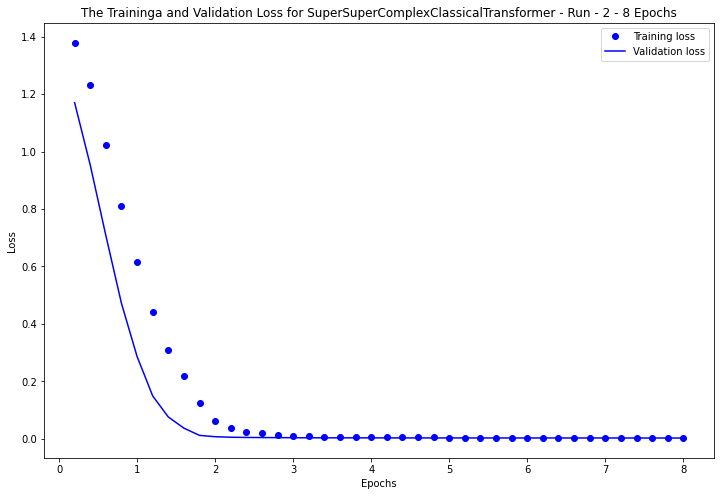

In [ ]:
plot_loss(train_loss,val_loss,2,ylimit=None,modelname="SuperSuperComplexClassicalTransformer")

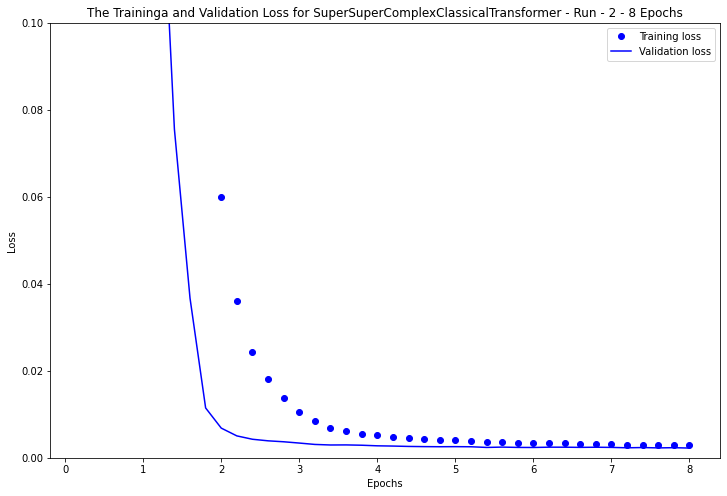

In [ ]:
plot_loss(train_loss,val_loss,2,ylimit=[0,0.1],modelname="SuperSuperComplexClassicalTransformer")

In [ ]:
train_loss, val_loss = train(CTransformer,train_dataloader,val_dataloader,2,20,
      loss_fn,optimizer,'cuda',1,grad_clip=1,scheduler = scheduler,
                             num_vocab=num_vocab,kind="FinestComplexPop")

  0%|          | 0/114022 [00:00<?, ?it/s]

EPOCHS  : 1/2 Loss: 2.819567
Validation loss: 2.273425

EPOCHS  : 1/2 Loss: 2.048602
Validation loss: 1.037932

EPOCHS  : 1/2 Loss: 0.556976
Validation loss: 0.010790

EPOCHS  : 1/2 Loss: 0.064860
Validation loss: 0.004116

EPOCHS  : 1/2 Loss: 0.015999
Validation loss: 0.003391

EPOCHS  : 1/2 Loss: 0.009558
Validation loss: 0.003197

EPOCHS  : 1/2 Loss: 0.007407
Validation loss: 0.003076

EPOCHS  : 1/2 Loss: 0.006239
Validation loss: 0.003067

EPOCHS  : 1/2 Loss: 0.005573
Validation loss: 0.002996

EPOCHS  : 1/2 Loss: 0.005086
Validation loss: 0.002931

Adjusting learning rate of group 0 to 1.0000e-06.


KeyboardInterrupt: ignored

In [ ]:
np.save("/content/drive/MyDrive/TransformerLoss/PredictiveComplexPopTransformer_run1_trainloss.npy",np.array(train_loss))
np.save("/content/drive/MyDrive/TransformerLoss/PredictiveComplexPopTransformer_run1_valloss.npy",np.array(val_loss))

In [ ]:
CTransformer.load_state_dict(torch.load("/content/drive/MyDrive/TransformerWeights/SecondFinestComplexPopTransformer-run-1-val_loss_0.64.pth"))

<All keys matched successfully>

In [ ]:
train_loss, val_loss = train(CTransformer,train_dataloader,val_dataloader,1,50,
      loss_fn,optimizer,'cuda',3,grad_clip=1,scheduler = scheduler,
                             num_vocab=num_vocab,kind="SecondFinestComplexPop")

  0%|          | 0/167711 [00:00<?, ?it/s]

EPOCHS  : 1/1 Loss: 3.306877
Validation loss: 2.941658

EPOCHS  : 1/1 Loss: 2.991991
Validation loss: 2.889391

EPOCHS  : 1/1 Loss: 2.943952
Validation loss: 2.860484



KeyboardInterrupt: ignored

In [ ]:
train_loss, val_loss = train(CTransformer,train_dataloader,val_dataloader,1,50,
      loss_fn,optimizer,'cuda',3,grad_clip=1,scheduler = scheduler,
                             num_vocab=num_vocab,kind="SecondFinestComplexPop")

  0%|          | 0/167711 [00:00<?, ?it/s]

EPOCHS  : 1/1 Loss: 3.056611
Validation loss: 2.859165

EPOCHS  : 1/1 Loss: 2.816294
Validation loss: 2.631329

EPOCHS  : 1/1 Loss: 2.646565
Validation loss: 2.458885

EPOCHS  : 1/1 Loss: 2.467681
Validation loss: 2.151442

EPOCHS  : 1/1 Loss: 2.074740
Validation loss: 0.933395

EPOCHS  : 1/1 Loss: 1.156832
Validation loss: 0.302369

EPOCHS  : 1/1 Loss: 0.707825
Validation loss: 0.110569

EPOCHS  : 1/1 Loss: 0.422203
Validation loss: 0.024984

EPOCHS  : 1/1 Loss: 0.202679
Validation loss: 0.006105

EPOCHS  : 1/1 Loss: 0.084802
Validation loss: 0.003173

EPOCHS  : 1/1 Loss: 0.047013
Validation loss: 0.002543

EPOCHS  : 1/1 Loss: 0.029947
Validation loss: 0.002286

EPOCHS  : 1/1 Loss: 0.020954
Validation loss: 0.002063

EPOCHS  : 1/1 Loss: 0.015915
Validation loss: 0.001966

EPOCHS  : 1/1 Loss: 0.012849
Validation loss: 0.001886

EPOCHS  : 1/1 Loss: 0.010533
Validation loss: 0.001801

EPOCHS  : 1/1 Loss: 0.008829
Validation loss: 0.001750

EPOCHS  : 1/1 Loss: 0.007438
Validation loss: 0.

In [ ]:
np.save("/content/drive/MyDrive/TransformerLoss/SecondFinestComplexPopTransformer_run1_trainloss.npy",np.array(train_loss))
np.save("/content/drive/MyDrive/TransformerLoss/SecondFinestComplexPopTransformer_run1_valloss.npy",np.array(val_loss))

# Generate music

In [ ]:
def generate_music(model,name,bar,start=2):
    # get tokenized remi representation of the music
    tokenizer = REMI() # initialize tokenizer
    folder = "Generated Music/Input/"
    #midi = MidiFile(folder+name+".mid") # classical
    midi = MidiFile(folder+name+".midi")
    events_MIDI = tokenizer.midi_to_tokens(midi)
    #print("event length: ", len(events_MIDI[0]))

    # extract events based on number of bars
    count_bars = 0
    start_position = start # since the first two events are bars
    events_MIDI = events_MIDI[0]
    position = start_position
    while count_bars < bar: # if the number of bars already satisfies the request, break
        
        #print(position)
        if events_MIDI[position] == 1:
            # if current position is a bar, then add number of bars counts
            count_bars+=1
            #print("bar: ",count_bars)
            #print("position: ", position)
            position += 1
        else:
            # if not, move to the next position
            position += 1
        if position + 1 == len(events_MIDI):
            #print("position: ", position)
            # if already reached the end of events, break
            break
    print("position: ", position)
    # now from beginning to position will have required number of bars (segment of music)
    input_seq = events_MIDI[start_position:position]

    # fed into model to obtain hidden state
    input_seq = torch.tensor(input_seq,dtype=torch.long)
    model.eval()
    #print(input_seq)
    op = model(input_seq.unsqueeze(0)) # (1,seq_len,218)
    op = op.squeeze(0) # (seq_len,218)
    op = nn.functional.softmax(op,dim=1)
    _, op = torch.max(op,1)
    op = op.detach().numpy()
    op = np.insert(op,0,1) # insert bar event in the beginning
    print(op)
    
    return op


In [ ]:
a = np.array([1,2,3])
a = np.insert(a,0,10)
a

array([10,  1,  2,  3])

## initialize model

In [ ]:
# get vocabulary size
from miditok import REMI, get_midi_programs
from miditoolkit import MidiFile
tokenizer = REMI()
num_vocab = len(tokenizer.vocab)

In [ ]:
# initialize model
embedding_size = 512
hidden_size = 512
num_layers = 2 # num of transformer encoder layers within transformer encoder
num_heads = 4
dropout = 0.25

transformer = Transformer(num_vocab,embedding_size,num_heads,hidden_size,num_layers,dropout)


In [ ]:
transformer.load_state_dict(torch.load("TransformerWeights/ComplexPopTransformer-run-1-val_loss_Best.pth"))

<All keys matched successfully>

In [ ]:
music = "001"
output_seq = generate_music(transformer.cpu(),music,5,1)

position:  153
[  1  36 106 125   1 107 125   1  29 107 125   1 186  24 107 125   1  24
 107 125   1  36 107 125   1  36 107 125   1  36 107 125   1  36 107 125
   1  36 105 129 190 107 125   1  29 106 125   1 186  24 107 125   1  36
 106 125   1  36 107 125   1  36 106 125   1  36 107 125   1  36 106 125
   1  36 105 129   1 108 125   1  29 106 129   1 186  24 108 125   1  36
 106 125   1  36 108 125   1  36 106 125   1  36 108 125   1  36 106 125
   1  36 105 125   1 108 125   1  29 106 125   1 186  24 108 125   1  36
 106 125   1  36 106 125   1 108 125   1  36 106 129   1  36 107 125   1
  36 106 125   1  36 105 125   1 186]


In [ ]:
model_name = "PopTransformer"
run = "1"
mode = "Best"

output_path = "Generated Music/"+model_name+"/"+music+"-run"+run+"-"+mode+".midi"
#music_path = "Generated Music/Input/" + music + ".mid" # classical
music_path = "Generated Music/Input/" + music + ".midi"
tokenizer = REMI()
midi = MidiFile(music_path)
output_midi = tokenizer.tokens_to_midi([output_seq],get_midi_programs(midi))

output_midi.dump(output_path)

Generated Music/PopTransformer/001-run1-Best.midi
